<img src="../../images/arm_logo.png" width=250 alt="ARM Logo"></img>

# The multipurpose ARM trajectory value-added product ([ARMTRAJ](https://www.arm.gov/data/science-data-products/vaps/armtraj))

---

## Overview
This notebook demonstrates the use of some of the datasets included in the multipurpose ARM trajectory value-added product (ARMTRAJ; [Silber et al., 2025](https://doi.org/10.5194/essd-17-29-2025)) to visualize and analyze the plausible source origin and properties of airmasses that overpassed the EPC ([EPCAPE](https://www.arm.gov/research/campaigns/amf2023EPCAPE)) deployment on August 20, 2023 (Hurricane Hilary — see [ARM's field note about the event](https://www.arm.gov/news/blog/post/91659)).

1. Introduction to ARMTRAJ
1. How to access the data and load using Xarray
1. Processing, analysis, and visualization

<br/><br/>
VAP references:
1. Silber, Israel, Comstock, Jennifer M., Kieburtz, Michael R., and Russell, Lynn M.: ARMTRAJ: a set of multipurpose trajectory datasets augmenting the Atmospheric Radiation Measurement (ARM) user facility measurements, Earth Syst. Sci. Data, 17, 29–42, https://doi.org/10.5194/essd-17-29-2025, 2025.
1. Silber, Israel, Comstock, Jennifer M, Kieburtz, Michael R, Gaustad, Krista L, and Mei, Fan.: ARM Trajectories Data Set Value-Added Product Report, DOE/SC-ARM-TR-314, https://doi.org/10.2172/2498401, 2024.


---

### Imports

In [1]:
import act
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

## Overview of ARMTRAJ

The multipurpose ARM trajectory VAP (ARMTRAJ) ameliorates knowledge gaps resulting from the Eulerian nature of ARM observations by providing airmass back and forward trajectory calculations. The VAP consists of six trajectory datasets initialized at ARM deployment coordinates and configured using ARM datasets. The six trajectory datasets support aerosol, cloud, planetary boundary layer, and related research (aerosol-cloud interactions, etc.). Trajectory calculations use the HYSPLIT model informed by the ERA5 reanalysis dataset at its highest spatial resolution (~31 km). ARMTRAJ data include ensemble run statistics that enhance trajectory consistency, while ensemble variability data serve as uncertainty metrics for airmass coordinates and state variables.

## How to Access ARMTRAJ Data from ARM

### Use the ARM Live API to Download the Data, using ACT

The Atmospheric Data Community Toolkit (ACT) has a helpful module to interface with the data server:
* [Download Data API](https://arm-doe.github.io/ACT/API/generated/act.discovery.html#module-act.discovery)

### Setup our Download Query
Before downloading our data, we need to make sure we have an ARM Data Account, and ARM Live token. Both of these can be found using this link:
- [ARM Live Signup](https://adc.arm.gov/armlive/livedata/home)

Once you sign up, you will see your token. Copy and replace that where we have `arm_username` and `arm_password` below.

Here, we will process ARMTRAJ's planetary boundary layer, surface, and cloud layer datasets, so we also need the names of those three datastreams, which are `epcarmtrajpblM1.c1`, `epcarmtrajsfcM1.c1`, and `epcarmtrajcldM1.c1`, respectively, representing:
- the site (EPC) and facility (M1)
    - This information corresponds to the EPCAPE main site in La Jolla, CA
- the product class (armtraj)
    - This is the value-added product described in this notebook
- the product type (pbl, sfc, and cld)
    - Those are the three datasets derived from this product. Note that ARMTRAJ also includes three additional trajectory datasets for cloud decks determined using the [ARSCL](https://www.arm.gov/data/science-data-products/vaps/arscl) VAP (arscl), ARM's [Crewed Facilities](https://www.arm.gov/capabilities/observatories/aaf/manned) and [Uncrewed Aerial Systems](https://www.arm.gov/capabilities/observatories/aaf/uas) flights (aaf), and [tethered balloon system](https://arm.gov/capabilities/instruments/tbs) flights (tbs)
- the data level (c1)
    - This is the corrected, quality-controlled data

In [3]:
arm_username = os.getenv("ARM_USERNAME")
arm_password = os.getenv("ARM_PASSWORD")

cld_datastream = "epcarmtrajcldM1.c1"
sfc_datastream = "epcarmtrajsfcM1.c1"
pbl_datastream = "epcarmtrajpblM1.c1"

start_date = "2023-08-20T00:00:00"
end_date = "2023-08-20T23:59:00"

cld_files = act.discovery.download_arm_data(arm_username,
                                             arm_password,
                                             cld_datastream,
                                             start_date,
                                             end_date)

sfc_files = act.discovery.download_arm_data(arm_username,
                                             arm_password,
                                             sfc_datastream,
                                             start_date,
                                             end_date)

pbl_files = act.discovery.download_arm_data(arm_username,
                                             arm_password,
                                             pbl_datastream,
                                             start_date,
                                             end_date)

[DOWNLOADING] epcarmtrajcldM1.c1.20230820.000000.nc

If you use these data to prepare a publication, please cite:

Zhang, D., & Silber, I. Airmass trajectories to support studies using ARM data
(ARMTRAJCLD), 2023-08-20 to 2023-08-20, ARM Mobile Facility (EPC), La Jolla, CA;
AMF1 (main site for EPCAPE on Scripps Pier) (M1). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/2309851

[DOWNLOADING] epcarmtrajsfcM1.c1.20230820.000000.nc

If you use these data to prepare a publication, please cite:

Zhang, D., & Silber, I. Airmass trajectories to support studies using ARM data
(ARMTRAJSFC), 2023-08-20 to 2023-08-20, ARM Mobile Facility (EPC), La Jolla, CA;
AMF1 (main site for EPCAPE on Scripps Pier) (M1). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/2309850

[DOWNLOADING] epcarmtrajpblM1.c1.20230820.000000.nc

If you use these data to prepare a publication, please cite:

Zhang, D., & Silber, I. Airmass trajectories to support stu

### Read and examine data files

In [4]:
traj_cld_ds = xr.open_mfdataset(cld_files)
traj_sfc_ds = xr.open_mfdataset(sfc_files)
traj_pbl_ds = xr.open_mfdataset(pbl_files)

---

We can start by examining the surface (SFC) 10-day back trajectory dataset. Note the fields with the `_ens` suffix, denoting ensemble run output. **We recommend using those ensemble output fields when possible, due to their robustness, and the possibility of using them (min, max, etc.) as uncertainty metrics**, as demonstrated below

In [5]:
traj_sfc_ds

<xarray.Dataset> Size: 2MB
Dimensions:                            (trajectory_time: 241,
                                        trajectory_type: 1, time: 8)
Coordinates:
  * trajectory_time                    (trajectory_time) int32 964B 0 1 ... 240
  * trajectory_type                    (trajectory_type) int32 4B -1
  * time                               (time) datetime64[ns] 64B 2023-08-20 ....
Data variables: (12/121)
    date                               (time, trajectory_time) datetime64[ns] 15kB dask.array<chunksize=(1, 241), meta=np.ndarray>
    latitude                           (time, trajectory_time) float64 15kB dask.array<chunksize=(1, 241), meta=np.ndarray>
    longitude                          (time, trajectory_time) float64 15kB dask.array<chunksize=(1, 241), meta=np.ndarray>
    height                             (time, trajectory_time) float64 15kB dask.array<chunksize=(1, 241), meta=np.ndarray>
    pres                               (time, trajectory_time) float64 15kB dask.array<chunksize=(1, 241), meta=np.ndarray>
    theta                              (time, trajectory_time) float64 15kB dask.array<chunksize=(1, 241), meta=np.ndarray>
    ...                                 ...
    wdir_1h_std_met                    (time) float64 64B dask.array<chunksize=(8,), meta=np.ndarray>
    time_offset                        (time) datetime64[ns] 64B dask.array<chunksize=(8,), meta=np.ndarray>
    base_time                          datetime64[ns] 8B ...
    lat                                float64 8B ...
    lon                                float64 8B ...
    alt                                float64 8B ...
Attributes: (12/21)
    mode:                                            sfc
    ensemble_size:                                   18
    ensemble_dx_from_center:                         [-7.5  0.   7.5] km
    ensemble_dy_from_center:                         [-7.5  0.   7.5] km
    ensemble_dz_from_center:                         [ 0 50] m
    used_era5_resolution:                            0.25 degrees
    ...                                              ...
    datastream:                                      epcarmtrajsfcM1.c1
    data_level:                                      c1
    facility_id:                                     M1
    site_id:                                         epc
    platform_id:                                     armtrajsfc
    history:                                         created by user isilber1...

We can also examine the PBL 5-day back trajectory file. Note that this product also has the `vert_layer` dimension, representing the different heights within the PBL layer. This dimension is also included in the ARSCL, CLD, AAF, and TBS ARMTRAJ datasets. The `_ft` suffix denotes trajectory model runs for the free troposphere, 200 m above the PBL top. Small ensemble runs are also included for these free-tropospheric starting coordinates. The ARMTRAJ ARSCL product includes an equivalent set of fields, whereas the AAF and TBS datasets incorporate an equivalent set of fields, but for the surface instead of the free-troposphere (hence, the `_sfc` suffix is used in some of those dataset fields).

In [6]:
traj_pbl_ds

<xarray.Dataset> Size: 984kB
Dimensions:                               (vert_layer: 3, trajectory_time: 121,
                                           trajectory_type: 1, time: 4)
Coordinates:
  * vert_layer                            (vert_layer) int32 12B 0 5 10
  * trajectory_time                       (trajectory_time) int32 484B 0 ... 120
  * trajectory_type                       (trajectory_type) int32 4B -1
  * time                                  (time) datetime64[ns] 32B 2023-08-2...
Data variables: (12/217)
    date                                  (time, trajectory_time) datetime64[ns] 4kB dask.array<chunksize=(1, 121), meta=np.ndarray>
    latitude                              (time, trajectory_time, vert_layer) float64 12kB dask.array<chunksize=(1, 121, 3), meta=np.ndarray>
    longitude                             (time, trajectory_time, vert_layer) float64 12kB dask.array<chunksize=(1, 121, 3), meta=np.ndarray>
    height                                (time, trajectory_time, vert_layer) float64 12kB dask.array<chunksize=(1, 121, 3), meta=np.ndarray>
    pres                                  (time, trajectory_time, vert_layer) float64 12kB dask.array<chunksize=(1, 121, 3), meta=np.ndarray>
    theta                                 (time, trajectory_time, vert_layer) float64 12kB dask.array<chunksize=(1, 121, 3), meta=np.ndarray>
    ...                                    ...
    pbl_height_bulk_richardson_pt5        (time) float32 16B dask.array<chunksize=(4,), meta=np.ndarray>
    time_offset                           (time) datetime64[ns] 32B dask.array<chunksize=(4,), meta=np.ndarray>
    base_time                             datetime64[ns] 8B ...
    lat                                   float64 8B ...
    lon                                   float64 8B ...
    alt                                   float64 8B ...
Attributes: (12/23)
    mode:                                            pbl
    arm_pblh_algorithm:                              pbl_height_bulk_richards...
    ensemble_size:                                   99
    ensemble_size_FT:                                9
    ensemble_dx_from_center:                         [-7.5  0.   7.5] km
    ensemble_dy_from_center:                         [-7.5  0.   7.5] km
    ...                                              ...
    datastream:                                      epcarmtrajpblM1.c1
    data_level:                                      c1
    facility_id:                                     M1
    site_id:                                         epc
    platform_id:                                     armtrajpbl
    history:                                         created by user isilber1...

Finally, we can examine the cloud (CLD) dataset. Note that, unlike the two datasets above, the `trajectory_type` dimension has a size of 2, indicating both back- and forward-trajectory data, which can be used to constrain model simulations, for example. Forward trajectories are also included in the ARMTRAJ ARSCL dataset.

In [7]:
traj_cld_ds

<xarray.Dataset> Size: 10MB
Dimensions:                            (vert_layer: 10, trajectory_time: 121,
                                        trajectory_type: 2, time: 4,
                                        time_dim_sonde: 10000)
Coordinates:
  * vert_layer                         (vert_layer) int32 40B 0 1 2 3 ... 7 8 9
  * trajectory_time                    (trajectory_time) int32 484B 0 1 ... 120
  * trajectory_type                    (trajectory_type) int32 8B -1 1
  * time_dim_sonde                     (time_dim_sonde) int32 40kB 1 2 ... 10000
  * time                               (time) datetime64[ns] 32B 2023-08-20T0...
Data variables: (12/119)
    date                               (time, trajectory_type, trajectory_time) datetime64[ns] 8kB dask.array<chunksize=(1, 2, 121), meta=np.ndarray>
    latitude                           (time, trajectory_type, trajectory_time, vert_layer) float64 77kB dask.array<chunksize=(1, 2, 121, 10), meta=np.ndarray>
    longitude                          (time, trajectory_type, trajectory_time, vert_layer) float64 77kB dask.array<chunksize=(1, 2, 121, 10), meta=np.ndarray>
    height                             (time, trajectory_type, trajectory_time, vert_layer) float64 77kB dask.array<chunksize=(1, 2, 121, 10), meta=np.ndarray>
    pres                               (time, trajectory_type, trajectory_time, vert_layer) float64 77kB dask.array<chunksize=(1, 2, 121, 10), meta=np.ndarray>
    theta                              (time, trajectory_type, trajectory_time, vert_layer) float64 77kB dask.array<chunksize=(1, 2, 121, 10), meta=np.ndarray>
    ...                                 ...
    liq_cld_top                        (time, vert_layer) float64 320B dask.array<chunksize=(1, 10), meta=np.ndarray>
    time_offset                        (time) datetime64[ns] 32B dask.array<chunksize=(4,), meta=np.ndarray>
    base_time                          datetime64[ns] 8B ...
    lat                                float64 8B ...
    lon                                float64 8B ...
    alt                                float64 8B ...
Attributes: (12/21)
    mode:                                            cld
    ensemble_size:                                   27
    ensemble_dx_from_center:                         [-7.5  0.   7.5] km
    ensemble_dy_from_center:                         [-7.5  0.   7.5] km
    ensemble_dz_from_center:                         [-50   0  50] m
    used_era5_resolution:                            0.25 degrees
    ...                                              ...
    datastream:                                      epcarmtrajcldM1.c1
    data_level:                                      c1
    facility_id:                                     M1
    site_id:                                         epc
    platform_id:                                     armtrajcld
    history:                                         created by user isilber1...

### Processing, analysis and visualization

---

Before examining the ARMTRAJ output, we need to define some handy processing and plotting routines that we will use below.

In [8]:
def set_none_to_slice_none(*args):
    """
    Convert all input parameters to slice(None) if input is None

    Returns
    -------
    out_args: tuple
        args values with None converted to slice(None)
    """
    out_args = []
    for arg in args:
        if arg is None:
            arg = slice(None)
        out_args.append(arg)
    out_args = tuple(out_args)
    return out_args


def set_map_fig(grid=None, cax_num=None, extent=None, projection=None, coast_res=None, land_color=None,
                ocean_color=None, add_states=False, add_borders=False, add_grid=True, grid_kws=None,
                fig_kws={}):
    """
    Generate a cartopy map figure and prepare axes for 1 or more colorbars

    Parameters
    ----------
    grid: 2-element tuple
        grid dimension to use in GridSpec. By default , a large number for the horz dim (2nd element) is
        recommended to allow a proportional colorbar.
    cax_num: int
        number of colorbar axes to allocate
    extent: 4-element list
        map extent to use [west edge, east edge, south edge, north edge].
    projection: cartopy.crs
        map projection to use from https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html.
        Using Mercator by default.
    coast_res: str
        coastline resolution to use. Choose from: ‘10m’, ‘50m’ (default), or ‘110m’.
    land_color=str or 3-element list or tuple
        land area color to use. Using 'lightgray' by default.
    ocean_color=str or 3-element list or tuple
        ocean area color to use. Using cartopy's 'water' color by default.
    add_states: bool
        If True, adding state boundaries (in black)
    add_borders: bool
        If True, adding country borders (in black)
    add_grid: bool
        adding grid lines if True.
    grid_kws: dict
        Input parameters for the grid call. By default: {"linewidth": 1.5, "draw_labels": True}.
    fig_kws: dict
        figure object keywords. Empty by default.

    Returns
    -------
    fig: matplotlib.figure.Figure
        figure object
    ax: cartopy.mpl.geoaxes.GeoAxes
        map axes object
    cax: list
        list of matplotlib.axes._axes.Axes objects (e.g., for colorbars)
    """
    if grid is None:
        grid = (5,20)
    if cax_num is None:
        cax_num = 1
    if extent is None:
        extent = [-180., 180., -90., 90.]
    if projection is None:
        projection = ccrs.Mercator()
    if coast_res is None:
        coast_res = "50m"
    if land_color is None:
        land_color = 'lightgray'
    if ocean_color is None:
        ocean_color = cfeature.COLORS['water']
    if grid_kws is None:
        grid_kws = {"linewidth": 1.5, "draw_labels": True}

    # set figure and grid
    fig = plt.figure(**fig_kws)
    gs = GridSpec(*grid, figure=fig)

    # Add main and colorbar axes
    cax = []
    ax = fig.add_subplot(gs[:, :grid[1] - cax_num], projection=projection)
    for cnt in range(cax_num):
        cax.append(fig.add_subplot(gs[:, grid[1] - (cax_num + cnt)]))

    # Set map
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution=coast_res)
    ax.add_feature(cfeature.LAND, facecolor=land_color)
    ax.add_feature(cfeature.OCEAN, facecolor=ocean_color)
    if add_states:
        ax.add_feature(cfeature.STATES)
    if add_borders:
        ax.add_feature(cfeature.BORDERS)
    if add_grid:
        gl = ax.gridlines(**grid_kws)

    return fig, ax, cax


def set_ts_fig(traj_ds, fields_2_plot=None, fig_kws={}):
    """
    Generate a time series figure and axes

    Parameters
    ----------
    traj_ds: xr.Dataset
        Trajectory dataset
    fields_2_plot: str or list
        name(s) of field(s) to plot (later, likely using the 'traj_tseries' method).
    fig_kws: dict
        figure object keywords. Empty by default.

    Returns
    -------
    fig: matplotlib.figure.Figure
        figure object
    ax: matplotlib.Axes
        axes object
    num_vars: int
        number of variables to plot (and rows in output figure)
    num_traj_per_pt: int
        number of trajectory types to plot (1 for back-trajectories; 2 for back- and fwd-trajectories)
    """
    # Characterize traj_ds and init associate variables
    if isinstance(fields_2_plot, str):
        num_vars = 1
    else:
        num_vars = len(fields_2_plot)
    num_traj_per_pt = traj_ds.sizes["trajectory_type"]  # Will be used to determine if one or two plot columns

    # Default input figure variables
    if "figsize" not in fig_kws.keys():
        fig_kws["figsize"] = (6 * num_traj_per_pt, 3 * num_vars)
    if "tight_layout" not in fig_kws.keys():
        fig_kws["tight_layout"] = True

    # Generate figure
    fig, ax = plt.subplots(num_vars, num_traj_per_pt, **fig_kws)

    return fig, ax, num_vars, num_traj_per_pt


def crop_traj_ds(traj_ds, time=None, time_ind=None, vert_layer=None, vert_layer_ind=None,
                 trajectory_type=None, trajectory_type_ind=None, trajectory_time=None,
                 trajectory_time_ind=None, set_9999_to_nan=True):
    """
    Crop input trajectory dataset

    Parameters
    ----------
    traj_ds: xr.Dataset
        Trajectory dataset
    time: np.datetime64 or slice or list of np.datetime64
        time values to crop.
    time_ind: int or slice or list of int
        time indices to crop.
    vert_layer: int or slice or list of int
        vertical layer value to crop.
    vert_layer_ind: int or slice or list of int
        vertical layer index to crop.
    trajectory_type: int or slice or list of int
        trajectory type to crop (if relevant; -1 for back trajectories, 1 for fwd trajectories).
    trajectory_type_ind: int or slice or list of int
        trajectory type index to crop (if relevant).
    trajectory_time: int or slice or list of int
        trajectory time(s) to crop.
    trajectory_time_ind: int or slice or list of int
        trajectory time index to crop.
    set_9999_to_nan: bool
        Set all typical FillValue of -9999 to nan. In that case, first creating a deep copy

    Returns
    -------
    crop_traj_ds: xr.Dataset
        Cropped trajectory dataset
    """
    # Set all None input to slices (full indexing)
    (time, time_ind, vert_layer, vert_layer_ind, trajectory_type, trajectory_type_ind, trajectory_time,
     trajectory_time_ind) = set_none_to_slice_none(
         time, time_ind, vert_layer, vert_layer_ind, trajectory_type, trajectory_type_ind,
         trajectory_time, trajectory_time_ind)

    crop_traj_ds = traj_ds.isel({"time": time_ind,
                                 "vert_layer": vert_layer_ind,
                                 "trajectory_time": trajectory_time_ind,
                                 "trajectory_type": trajectory_type_ind}, missing_dims="ignore")
    if "time" in crop_traj_ds.sizes:
        if isinstance(time, np.datetime64):
            crop_traj_ds = crop_traj_ds.sel(time=time, method='nearest')
        else:
            crop_traj_ds = crop_traj_ds.sel(time=time)
    if "vert_layer" in crop_traj_ds.sizes:
        crop_traj_ds = crop_traj_ds.sel(vert_layer=vert_layer)
    if "trajectory_time" in crop_traj_ds.sizes:
        crop_traj_ds = crop_traj_ds.sel(trajectory_time=trajectory_time)
    if "trajectory_type" in crop_traj_ds.sizes:
        crop_traj_ds = crop_traj_ds.sel(trajectory_type=trajectory_type)

    if set_9999_to_nan:
        crop_traj_ds = crop_traj_ds.copy(deep=True).where(lambda x: x != -9999)

    return crop_traj_ds


def plot_traj(traj_ds, ax, lon_fieldname, lat_fieldname, color_fieldname=None, grad_color_curve=True,
              time=None, time_ind=None, vert_layer=None, vert_layer_ind=None, trajectory_type=None,
              trajectory_type_ind=None, trajectory_time=None, trajectory_time_ind=None,
              add_cbar=True, cbar_kws={}, title=None, cbar_title=False,
              no_cbar_ticks=False, add_site=True, specific_sites=[], **kwargs):
    """
    Plot trajectories onto a map axes and add colorbar if relevant

    Parameters
    ----------
    traj_ds: xr.Dataset
        Trajectory dataset
    ax: cartopy.mpl.geoaxes.GeoAxes
        map axes object
    lon_fieldname: str
        longitude field name (e.g., "lon" or "lon_ens_mean").
    lat_fieldname: str
        latitude field name (e.g., "lat" or "lat_ens_mean").
    color_fieldname: str
        field name to use in gradient color (if grad_color_curve=True).
    grad_color_curve: bool
        Plot gradient color line if True.
    time: np.datetime64 or slice or list of np.datetime64
        time values to crop.
    time_ind: int or slice or list of int
        time indices to crop.
    vert_layer: int or slice or list of int
        vertical layer value to crop.
    vert_layer_ind: int or slice or list of int
        vertical layer index to crop.
    trajectory_type: int or slice or list of int
        trajectory type to crop (if relevant; -1 for back trajectories, 1 for fwd trajectories).
    trajectory_type_ind: int or slice or list of int
        trajectory type index to crop (if relevant).
    trajectory_time: int or slice or list of int
        trajectory time(s) to crop.
    trajectory_time_ind: int or slice or list of int
        trajectory time index to crop.
    add_cbar: bool
        add colorbar and return object if True (and if grad_color_curve=True).
    cbar_kws: dict
        bolorbar keyword input parameters.
    title: str
        axis title
    cbar_title: str or bool
        colorbar title if str, field units if bool and True.
    no_cbar_ticks: bool
        remove tick values from colorbar if True
    add_site: bool
        add markers to target site if True.
    specific_sites: list
        If not empty, only sites in this list (including all facilities) will be included.

    Returns
    -------
    line_obj: matplotlib.collections.LineCollection or matplotlib.line
        line object.
    cb: matplotlib.colorbar.Colorbar
        (optional) colorbar object.
    """
    # Crop input dataset (first crop by indices; then by values)
    traj_tmp = crop_traj_ds(traj_ds, time, time_ind, vert_layer, vert_layer_ind, trajectory_type,
                            trajectory_type_ind, trajectory_time, trajectory_time_ind)

    # Now plot
    if title is not None:
        ax.set_title(title)
    if grad_color_curve:
        line_obj = ax.scatter(traj_tmp[lon_fieldname], traj_tmp[lat_fieldname], c=traj_tmp[color_fieldname],
                              transform=ccrs.PlateCarree(), **kwargs)
        if add_cbar:
            cb = plt.colorbar(line_obj, **cbar_kws)
            if no_cbar_ticks:  # remove ticks from colorbar (e.g., to prevent duplicates)
                cb.set_ticks([])
            if cbar_title is not None:
                if isinstance(cbar_title, str):
                    cb.set_label(cbar_title)
                elif cbar_title:
                    #cb.set_label(f"${traj_tmp[color_fieldname].attrs['units']}$")
                    cb.set_label(f"{traj_tmp[color_fieldname].attrs['long_name']} [${traj_tmp[color_fieldname].attrs['units']}$]")
    else:
        line_obj = ax.scatter(traj_tmp[lon_fieldname], traj_tmp[lat_fieldname],
                              transform=ccrs.PlateCarree(), **kwargs)

    # Add ARM site to map
    if add_site:
        ax.scatter(traj_tmp["lon"], traj_tmp["lat"], s=60, c='r', edgecolor='k', transform=ccrs.PlateCarree(), zorder=100)

    # Set output variables
    output_objs = [line_obj]
    if grad_color_curve & add_cbar:
        output_objs.append(cb)

    return tuple(output_objs)


def traj_tseries(traj_ds, ax, num_vars, num_traj_per_pt, fields_2_plot=None, time=None, time_ind=None,
                 vert_layer=None, vert_layer_ind=None, trajectory_type=None, trajectory_type_ind=None,
                 trajectory_time=None, trajectory_time_ind=None,
                 plot_center=True, plot_ens_mean=True, plot_ens_sd=True, plot_ens_min_max=True,
                 day_xtick=False):
    """
    Plot a time series of trajectory variables including mean value and ensemble mean ± SD, min, and max.

    Parameters
    ----------
    traj_ds: xr.Dataset
        Trajectory dataset
    ax: matplotlib.Axes
        axes object
    num_vars: int
        number of variables to plot (and rows in output figure)
    num_traj_per_pt: int
        number of trajectory types to plot (1 for back-trajectories; 2 for back- and fwd-trajectories)
    fields_2_plot: str or list
        name(s) of field(s) to plot
    time: np.datetime64 or slice or list of np.datetime64
        time values to crop.
    time_ind: int or slice or list of int
        time indices to crop.
    vert_layer: int or slice or list of int
        vertical layer value to crop.
    vert_layer_ind: int or slice or list of int
        vertical layer index to crop.
    trajectory_type: int or slice or list of int
        trajectory type to crop (if relevant; -1 for back trajectories, 1 for fwd trajectories).
    trajectory_type_ind: int or slice or list of int
        trajectory type index to crop (if relevant).
    trajectory_time: int or slice or list of int
        trajectory time(s) to crop.
    trajectory_time_ind: int or slice or list of int
        trajectory time index to crop.
    plot_center: bool
        plot variables along trajectories for center coordinates
    plot_ens_mean: bool
        plot variables along ensemble mean trajectory (for ERA5 sfc properties) or ensemble mean values.
    plot_ens_sd: bool
        plot variable ensemble standard deviation as a filled polygon.
    plot_ens_min_max: bool
        plot variable ensemble min/max values
    day_xtick: bool
        if True, set xticks to have day units.
    """
    # Crop input dataset (first crop by indices; then by values)
    traj_tmp = crop_traj_ds(traj_ds, time, time_ind, vert_layer, vert_layer_ind, trajectory_type,
                            trajectory_type_ind, trajectory_time, trajectory_time_ind)

    if isinstance(fields_2_plot, str):
        fields_2_plot = [fields_2_plot]

    # Characterize traj_ds and init associate variables
    traj_types = ["back", "fwd"]  # used for titles
    vert_layer_in = "vert_layer" in traj_tmp['latitude'].sizes  # for center
    vert_layer_in_ens = "vert_layer" in traj_tmp['latitude_ens_min'].sizes  # for ensemble
    traj_types = traj_types[:num_traj_per_pt]  # We will never (in any expected form) have fwd w/o/ back-traj
    ax_index = [slice(None)] * num_traj_per_pt
    arr_index = [slice(None)] * num_traj_per_pt # indices for field plotting

    # Loop over trajectory types and selected variables and plot accordingly.
    for traj_type, traj_ind in zip(traj_types, range(num_traj_per_pt)):
        xvar = traj_tmp["trajectory_time"].values
        if num_traj_per_pt > 1:
            ax_index[1] = traj_ind
            arr_index[0] = traj_ind
        for variable, var_ind in zip(fields_2_plot, range(num_vars)):
            ax_index[0] = var_ind
            if plot_ens_min_max & (f"{variable}_ens_max" in traj_tmp.keys()):  # second condition excludes ERA5 prop
                traj_tmp[f"{variable}_ens_max"][tuple(arr_index)].plot(ax=ax[tuple(ax_index)],
                                                                          label='ensemble min/max', c='darkslategrey', linestyle='--')
                traj_tmp[f"{variable}_ens_min"][tuple(arr_index)].plot(ax=ax[tuple(ax_index)],
                                                                          label='__no_legend__', c='darkslategrey', linestyle='--')
            if plot_ens_mean:
                traj_tmp[f"{variable}_ens_mean"][tuple(arr_index)].plot(ax=ax[tuple(ax_index)],
                                                                           label='Ensemble mean', c='grey')
            if plot_center:
                traj_tmp[f"{variable}"][tuple(arr_index)].plot(ax=ax[tuple(ax_index)], label='Center coords', c='green')
            if plot_ens_sd & (f"{variable}_ens_std" in traj_tmp.keys()):  # second condition excludes ERA5 prop
                ax[tuple(ax_index)].fill_between(
                    xvar,
                    traj_tmp[f"{variable}_ens_mean"][tuple(arr_index)] -
                    traj_tmp[f"{variable}_ens_std"][tuple(arr_index)],
                    traj_tmp[f"{variable}_ens_mean"][tuple(arr_index)] +
                    traj_tmp[f"{variable}_ens_std"][tuple(arr_index)],
                    label='ensemble mean ' + u"\u00B1" r' 1$\sigma$', alpha=0.5, facecolor='silver')
            if day_xtick:
                ax[tuple(ax_index)].set_xticks(np.arange(0, xvar.max() + 1e-10, 24))
                ax[tuple(ax_index)].set_xlim((0., xvar.max()))
            if traj_ind == 0:  # invert back trajectory
                ax[tuple(ax_index)].invert_xaxis()
            else:  # set a fixed y-axis range for back and fwd trajectory cases (produces smoother plots)
                ylim = (np.minimum(ax[var_ind, 0].get_ylim()[0], ax[var_ind, 1].get_ylim()[0]),
                        np.maximum(ax[var_ind, 0].get_ylim()[1], ax[var_ind, 1].get_ylim()[1]))
                ax[var_ind, 0].set_ylim(ylim)
                ax[var_ind, 1].set_ylim(ylim)
            if var_ind < num_vars - 1:  # xlabels and x-axis tick values only at the bottom
                ax[tuple(ax_index)].set_xticklabels([])
                ax[tuple(ax_index)].set_xlabel("")
            elif day_xtick:
                ax[tuple(ax_index)].set_xticklabels((ax[tuple(ax_index)].get_xticks() / 24).astype(int))
                ax[tuple(ax_index)].set_xlabel("Days offset from start time")
            else:
                ax[tuple(ax_index)].set_xlabel("Offset from start time [h]")
            if var_ind == 0:  # title only on top
                ax[tuple(ax_index)].set_title(
                    f"{traj_type} trajectory ({traj_tmp['time'].values[time_ind].astype('datetime64[m]').item()} UTC)")
                if traj_ind == 0:
                    ax[tuple(ax_index)].legend()
            else:
                ax[tuple(ax_index)].set_title("")

Let's start this short exploration and visualization of the data with the cloud trajectory dataset. We like to examine the airmass origin of a mid-level embedded liquid layer detected using the 13:00 UTC sounding profile, several hours after Hurricane Hilary made landfall in Southern California as a tropical storm. We set the relevant time value, a value of '-1' for the trajectory type (back-trajectories), and a layer index value of 0 (i.e., the lowest out of the five layers detected using [SONDE](https://www.arm.gov/capabilities/instruments/sonde), indicated above by the `number_of_starting_center_points_per_time_step` global attributes of the `traj_cld_ds` object). We then crop the dataset, selecting the relevant coordinates, and use the plotting routine defined above to easily plot the 5-day trajectories for the center coordinates (EPCAPE main site) and the ensemble mean on a map with large markers in 24-hour increments.

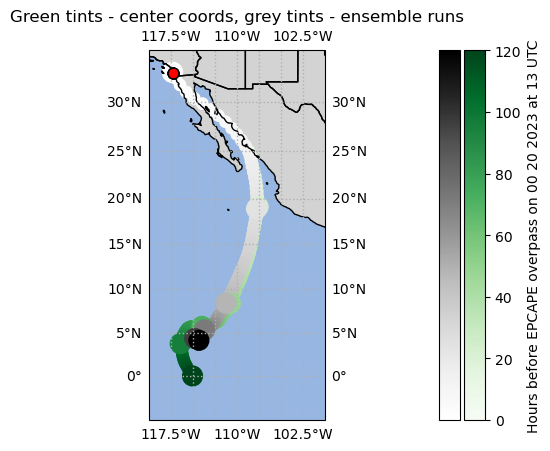

In [9]:
# Set coordinate indices and values
traj_type = -1  # trajectory type value (back-trajectory in this case)
vert_layer_ind = 0  # vertical layer index (not value)
time = np.datetime64('2023-08-20T13:00:00')  # time index

# crop, set extent, and determine central longitude for map
crop_traj = crop_traj_ds(traj_cld_ds, time=time, vert_layer_ind=vert_layer_ind, trajectory_type=traj_type)
extent = [-120.0, -100.0, -5.0, 35.0]
central_longitude = -110.0

# Generate figure and axes objects
fig, ax, cax = set_map_fig(cax_num=2,
                           extent=extent,
                           projection=ccrs.Mercator(central_longitude=central_longitude),
                           grid_kws={"linewidth": 1.0, "draw_labels": True, 'linestyle': ':'},
                           add_states=True,
                           add_borders=True)

# plot trajectories and export
plot_traj(crop_traj, ax, "longitude", "latitude", "trajectory_time", cbar_kws={"cax": cax[0]},
          cmap='Greens', linewidth=3,
          cbar_title=f"Hours before EPCAPE overpass on {pd.to_datetime(time).strftime('%M %d %Y at %H UTC')}")
plot_traj(crop_traj, ax, "longitude_ens_mean", "latitude_ens_mean", "trajectory_time", cbar_kws={"cax": cax[1]},
          no_cbar_ticks=True, cmap='Greys', linewidth=3,
          title="Green tints - center coords, grey tints - ensemble runs")
plot_traj(crop_traj.isel(trajectory_time=np.arange(0, 121, 24)), ax, "longitude", "latitude", "trajectory_time",
                 cmap='Greens', linewidth=3, s=150, add_cbar=False)
plot_traj(crop_traj.isel(trajectory_time=np.arange(0, 121, 24)), ax, "longitude_ens_mean", "latitude_ens_mean", "trajectory_time",
                 cmap='Greys', linewidth=3, s=150, add_cbar=False)
fig.savefig(f'./armtraj_cld_{time}.png', dpi=150)

As we can see here, the ensemble mean is close (to a large extent) to the center coordinates output, indicating robust results and likely that large-scale meteorology dominates this airmass. As demonstrated below, we can use the same plotting methods to depict the evolution of various dataset variables as the airmass was advected to the ground-based site. We can see that several hours before the cloud layer was observed roughly 3 km above EPCAPE (as part of the now-tropical storm Hilary), the airmass monotonically ascended and cooled adiabatically, forced by cyclone dynamics, consistent with the ensemble mean versus center coordinates shown above.

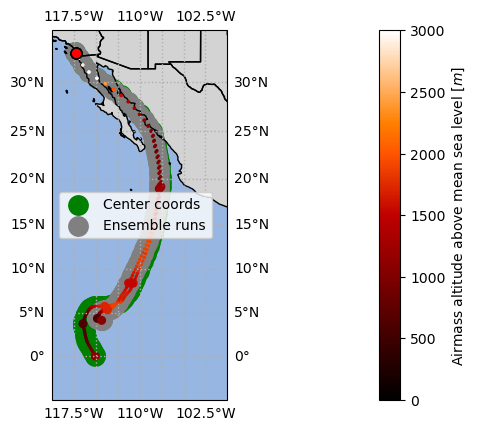

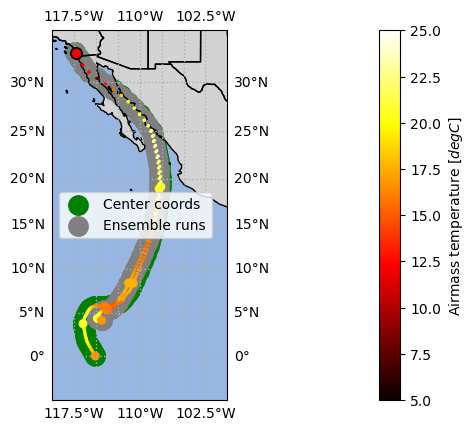

In [10]:
# Set field and attributes to plot
fields = {'altitude': {"title": "Altitude",
                "vmin": 0.0,
                "vmax": 3000.0,
                "cmap": "gist_heat"},
          'temp': {"title": "Temperature",
                   "vmin": 5.,
                   "vmax": 25.,
                   "cmap":  "hot"},
         }

# Generate figure, plot uniform color trajectories, and overlay the data fields. Then export
for key in fields.keys():
    fig, ax, cax = set_map_fig(
        cax_num=1, extent=extent, projection=ccrs.Mercator(central_longitude=central_longitude),
        grid_kws={"linewidth": 1.0, "draw_labels": True, 'linestyle': ':'}, add_states=True, add_borders=True)
    plot_traj(crop_traj, ax, "longitude", "latitude", c='green', grad_color_curve=False, label='Center coords', linewidth=9)
    plot_traj(crop_traj, ax, "longitude_ens_mean", "latitude_ens_mean", c='grey', grad_color_curve=False, label='Ensemble runs',
              linewidth=9)
    plot_traj(crop_traj, ax, "longitude", "latitude", key, cbar_kws={"cax": cax[0]}, cmap=fields[key]['cmap'],
              s=2, label='__nolegend__', cbar_title=True,
              vmin=fields[key]['vmin'], vmax=fields[key]['vmax'], zorder=2)
    plot_traj(crop_traj.isel(trajectory_time=np.arange(0, 121, 24)), ax,
              "longitude", "latitude", key, cbar_kws={"cax": cax[0]}, cmap=fields[key]['cmap'],
              s=30, label='__nolegend__', cbar_title=True,
              vmin=fields[key]['vmin'], vmax=fields[key]['vmax'], zorder=2)
    plot_traj(crop_traj, ax, "longitude_ens_mean", "latitude_ens_mean", key, cmap=fields[key]['cmap'],
              s=2, add_cbar=False, label='__nolegend__',
              vmin=fields[key]['vmin'], vmax=fields[key]['vmax'], zorder=3)
    plot_traj(crop_traj.isel(trajectory_time=np.arange(0, 121, 24)), ax,
              "longitude_ens_mean", "latitude_ens_mean", key, cmap=fields[key]['cmap'],
              s=30, add_cbar=False, label='__nolegend__',
              vmin=fields[key]['vmin'], vmax=fields[key]['vmax'], zorder=3)
    ax.legend(loc='center left')
    fig.savefig(f"./armtraj_cld_{time}_{key}_data.png", dpi=150)

Let's generate a time series figure that combines the backward and forward trajectories to gain more insights. Here, we utilize another plotting routine defined above, allowing for quick time series plotting of specified variable names. Note the automated continuity of variables at time 0, which enables an unbiased evaluation. We can see that the forward trajectories exhibit much greater variability than the back trajectories.

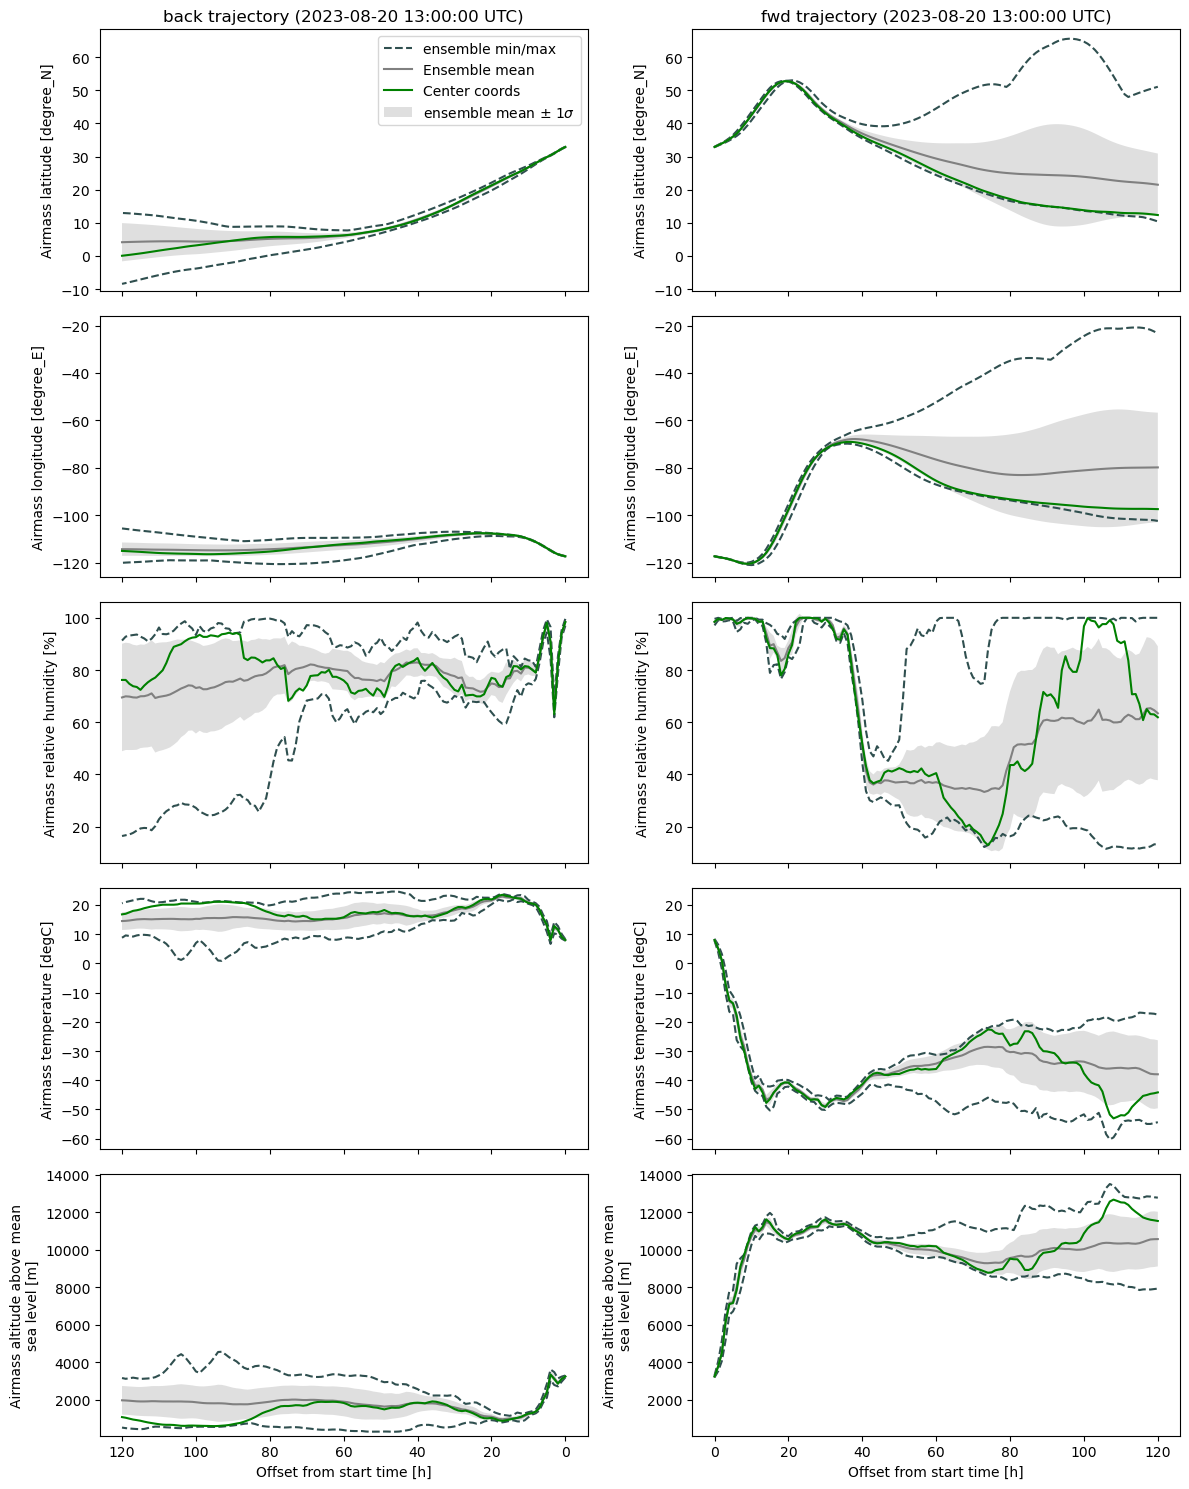

In [11]:
# Crop only the time and layer index but retain back- and forward trajectory data
crop_traj = crop_traj_ds(traj_cld_ds, time=time, vert_layer_ind=vert_layer_ind)

# Set fields to plot
fields_2_plot = ['latitude', 'longitude', 'rh', "temp", 'altitude']
num_traj_per_pt = crop_traj.sizes["trajectory_type"]  # Will be used to determine if one or two plot columns
num_vars = len(fields_2_plot)

# generate plot and export
fig, ax, num_vars, num_traj_per_pt = set_ts_fig(crop_traj, fields_2_plot=fields_2_plot)
traj_tseries(crop_traj, ax, num_vars, num_traj_per_pt, fields_2_plot=fields_2_plot)
fig.savefig(f'./armtraj_cld_{time}_tseries.png', dpi=150)

Let's examine what was happening at lower levels by inspecting the 'PBL' dataset. We will examine the PBL mid-region and the free-troposphere, just (200 m) above the PBL. We use a vertical layer index of 1 (or an absolute value of 5) for the PBL mid-region and the '_ft' suffix for the free troposphere field names. Note that, because the PBL dataset utilizes a sounding-based [PBLH VAP](https://www.arm.gov/data/science-data-products/vaps/pblht), we can use the same time index as in the CLD dataset. Also note that while Hilary is still influencing the atmosphere aloft, the PBLH, at least this early in the morning (local time), is set at merely 69 m AMSL. We can see that the spread in the free troposphere is quite large, but is much greater within the PBL (because we sample many starting heights within the PBL, among other reasons). This spread is manifested essentially in all variables.
Also worth noting is that the center coordinate trajectories are occasionally at the ensemble extremes, underscoring our recommendation for using ensemble runs over center coordinates.

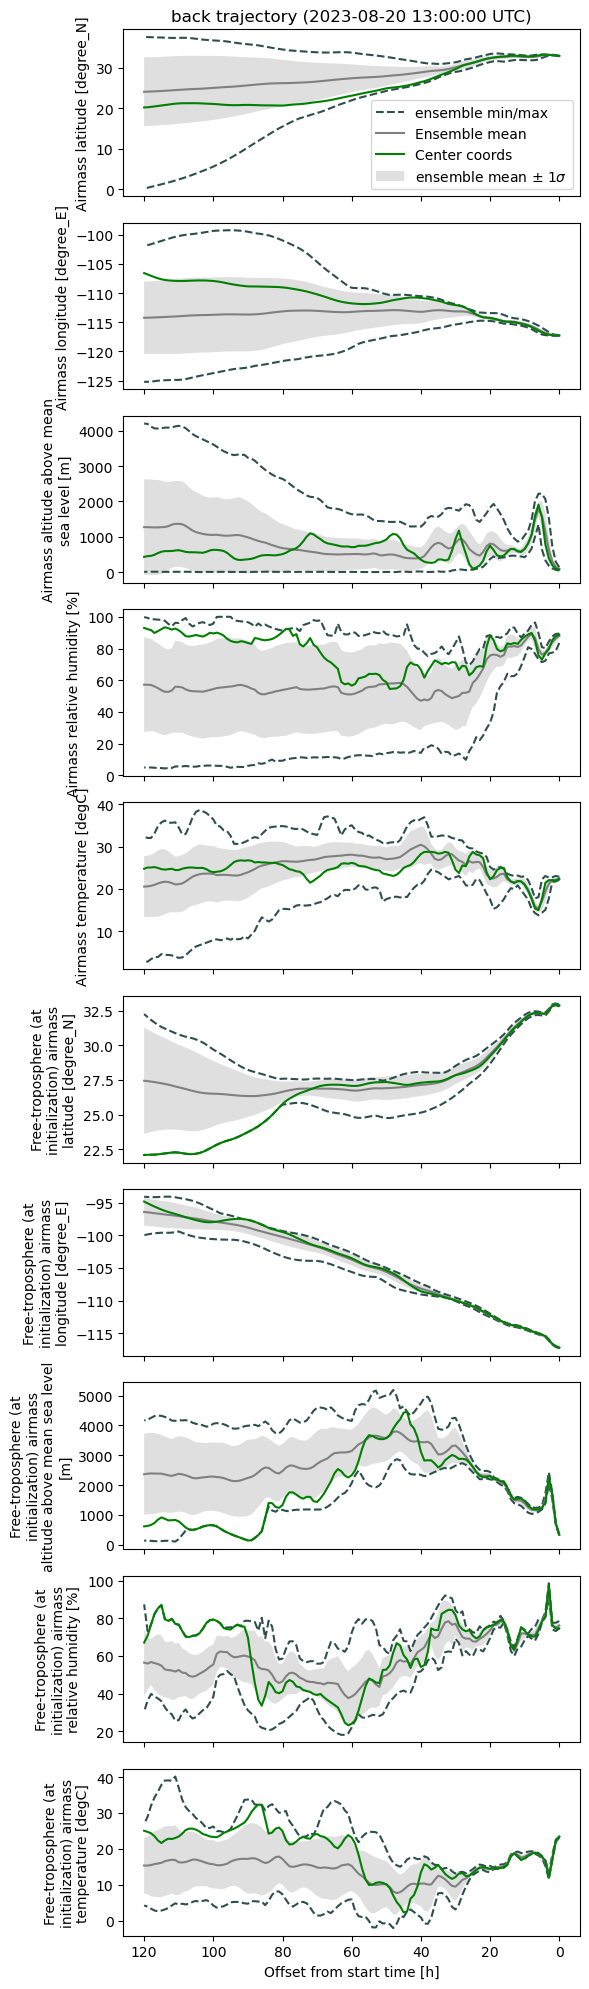

In [12]:
# crop the dataset
vert_layer_ind = 1  # use index '1' for the PBL mid(value of 5 per the vert_layer field metadata shown above)
crop_traj = crop_traj_ds(traj_pbl_ds, time=time, vert_layer_ind=vert_layer_ind)

# Set fields to plot
fields_2_plot = ['latitude', 'longitude', 'altitude', 'rh', "temp",
                 'latitude_ft', 'longitude_ft', 'altitude_ft', 'rh_ft', "temp_ft"]  # set variables in dataset to plot

# Generate the figure and export
fig, ax, num_vars, num_traj_per_pt = set_ts_fig(crop_traj, fields_2_plot=fields_2_plot, fig_kws={"figsize": (6, 20)})
traj_tseries(crop_traj, ax, num_vars, num_traj_per_pt, fields_2_plot=fields_2_plot)
fig.savefig(f'./armtraj_pbl_{time}_tseries.png', dpi=150)

Finally, we examine the surface dataset. We first select the time closest to the PBL and cloud dataset cases, which, given the 3-h surface dataset resolution, corresponds to 12 UTC.
With the extended 10-day back-trajectory period provided by this dataset, the trajectories exhibit a significant spread. Here, we also observe that the airmass entrained and primarily remained within the PBL only during the two days preceding the EPCAPE overpass, as indicated by the airmass height-to-PBL height ratio remaining around a value of 1 (PBLH derived from ERA5). This extensive mixed-layer history suggests that soil and vegetation type data (harvested from ERA5; shown below and included among other surface properties in all trajectory datasets) along the trajectory might inform on particle chemistry (e.g., using source-attribution methods).

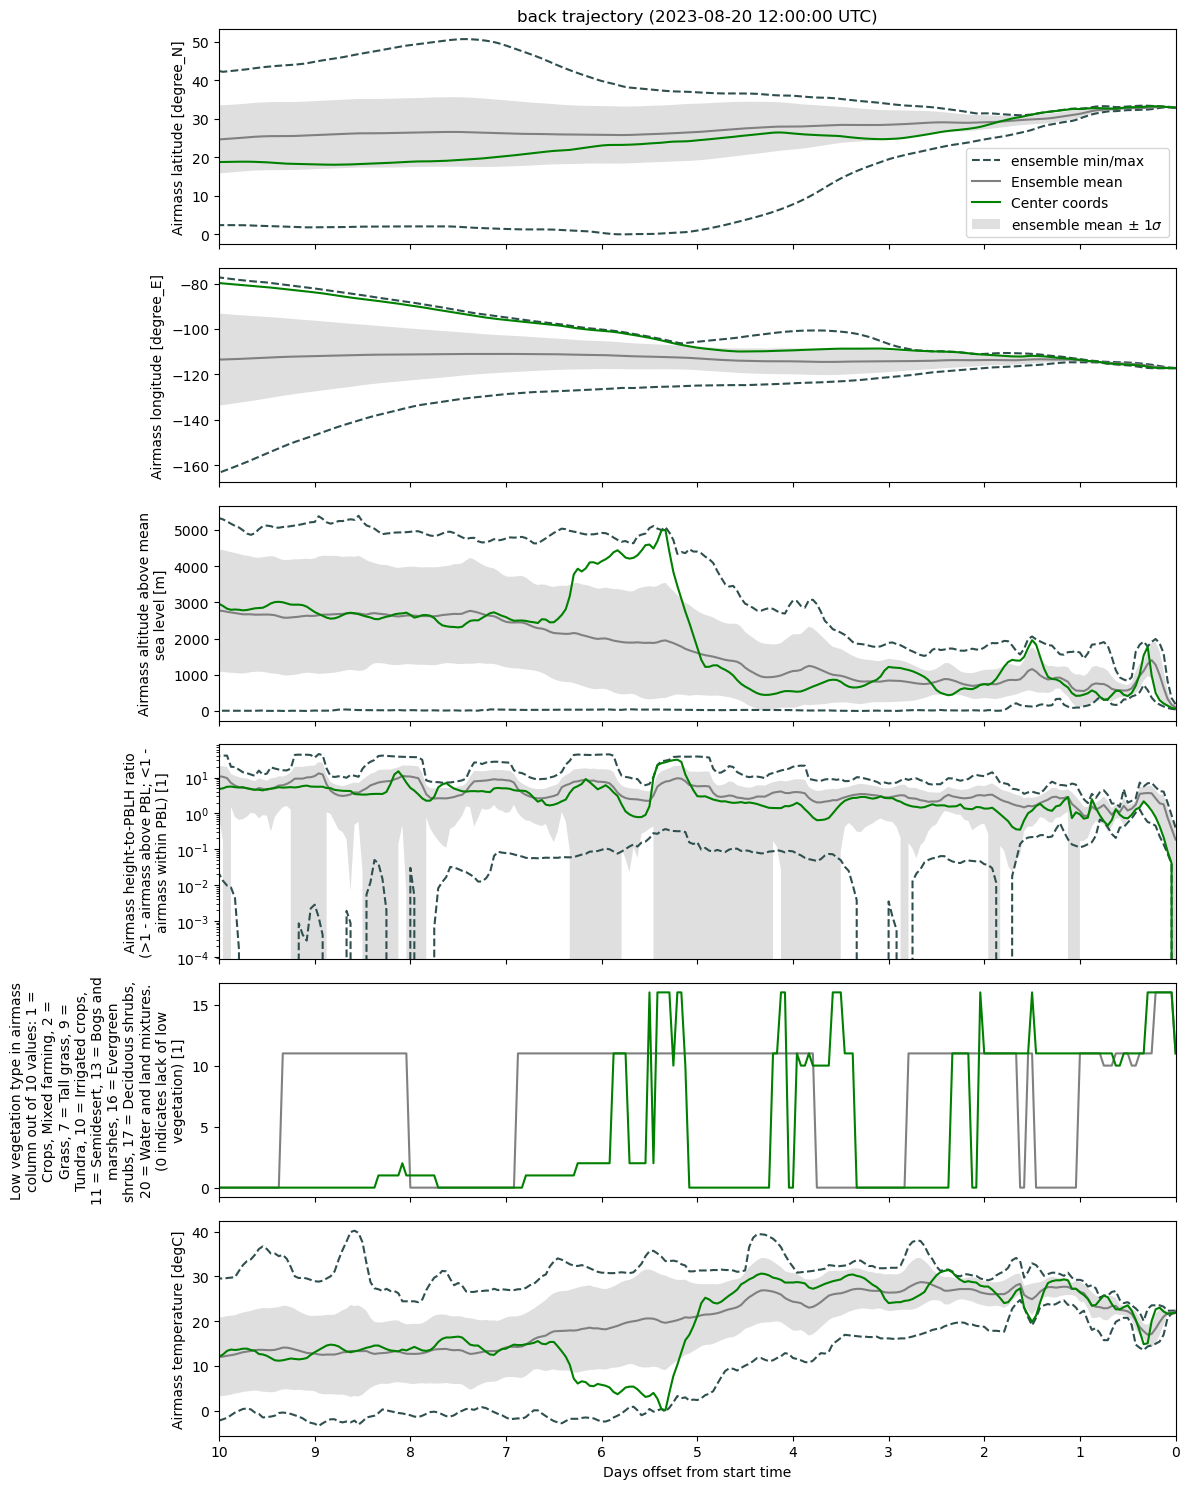

In [13]:
# crop the dataset
crop_traj = crop_traj_ds(traj_sfc_ds, time=time)

# Set fields to plot
fields_2_plot = ['latitude', 'longitude', 'altitude', "height_to_pblh_ratio", "low_vegetation_type", "temp"]

# generate figure and export
fig, ax, num_vars, num_traj_per_pt = set_ts_fig(crop_traj, fields_2_plot=fields_2_plot)
traj_tseries(crop_traj, ax, num_vars, num_traj_per_pt, fields_2_plot=fields_2_plot, day_xtick=True)
ax[3].set_yscale("log")  # Set airmass height-to-PBLH-ratio values depicted in log-scale.
fig.savefig(f'./armtraj_sfc_{time}_tseries.png', dpi=150)

The spread, or difference, between the center-coordinate trajectory and the ensemble is not the general "rule" (readers are referred to the related discussion in [Silber et al., 2025](https://doi.org/10.5194/essd-17-29-2025)) When we examine the center vs. the ensemble mean trajectories at different times, we see consistency between trajectory pattern, direction, and range before the tropical storm started to influence the site. There is a clear marine-dominated flow in those cases (06 UTC and earlier). In the following trajectory times, the variability becomes increasingly erratic (as also indicated by the minimum and maximum values of the variables; not shown). We think that those and other ARMTRAJ outputs presented above merit a detailed analysis beyond the scope of this demo, which now comes to an end.

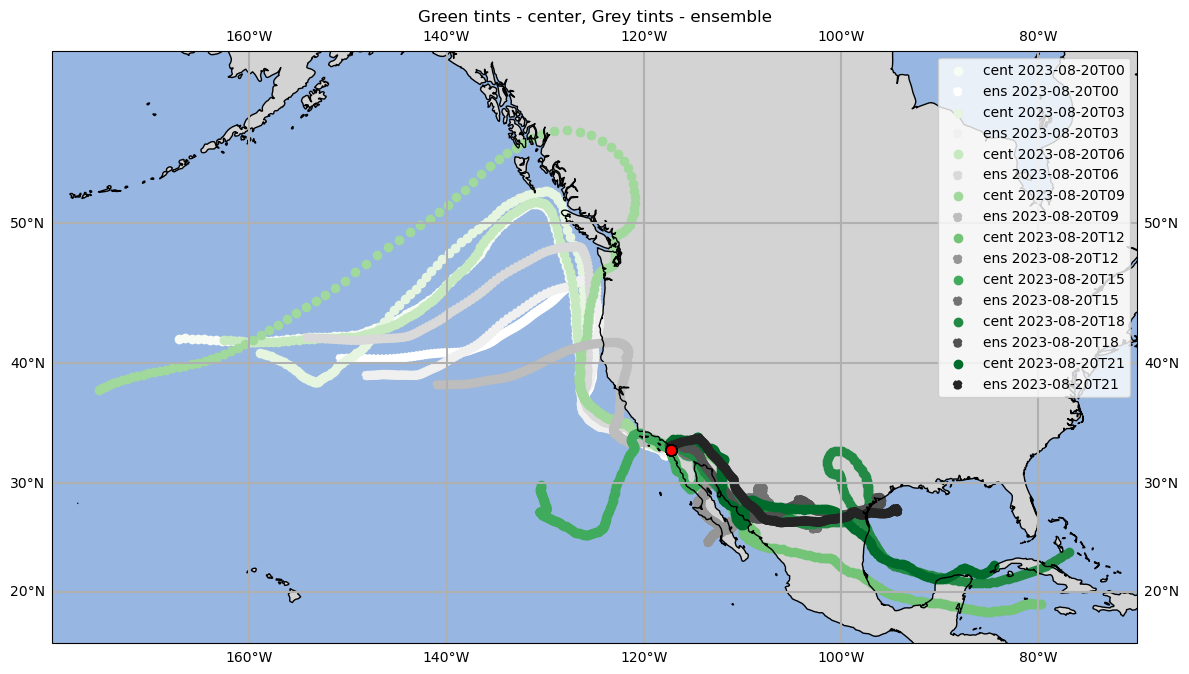

In [121]:
# Get a colormap for line plots
cmap = matplotlib.colormaps['Greens']
cmap_ens = matplotlib.colormaps['Greys']

# set extent and generate figure and axes objects
extent = [-180.0, -70.0, 15.0, 60.0]
central_longitude = -120.0
fig, ax, cax = set_map_fig(cax_num=0, extent=extent, projection=ccrs.Mercator(central_longitude=central_longitude),
                              fig_kws={'figsize':(14, 8)})

for time_ind in range(traj_sfc_ds["time"].size):
    # set line colors
    rgba = cmap(time_ind / traj_sfc_ds["time"].size)
    rgba_ens = cmap_ens(time_ind / traj_sfc_ds["time"].size)

    # crop the dataset
    crop_traj = crop_traj_ds(traj_sfc_ds, time_ind=time_ind)

    # add trajectory curves
    plot_traj(crop_traj, ax, "longitude", "latitude", grad_color_curve=False, color=rgba,
              label=f"cent {crop_traj['time'].values.astype('datetime64[h]')}")
    plot_traj(crop_traj, ax, "longitude_ens_mean", "latitude_ens_mean", grad_color_curve=False, color=rgba_ens,
              linestyle='--', label=f"ens {crop_traj['time'].values.astype('datetime64[h]')}",
              title="Green tints - center, Grey tints - ensemble")

# add legend and export
ax.legend()
fig.savefig(f'./armtraj_sfc_{time.astype("datetime64[D]")}_variable_times.png', dpi=150)